# Long-Short Strategy, Part 2: Trading signals with LightGBM and CatBoost

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. `trading_signals_with_lightgbm_and_catboost`  (this noteboook): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

We'll subset the dataset created in the preceding notebook through the end of 2016 to cross-validate several model configurations for various lookback and lookahead windows, as well as different roll-forward periods and hyperparameters. 

Our approach to model selection will be similar to the one we used in the previous chapter and uses the custom `MultipleTimeSeriesCV` introduced in [Chapter 7, Linear Models – From Risk Factors to Return Forecasts](../07_linear_models).

## Imports & Settings

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
project_path = Path(r'C:/Users/flyin/OneDrive/Desktop/autotrade/new/machine-learning-for-trading')
sys.path.append(str(project_path))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
sns.set_style('whitegrid')

In [6]:
YEAR = 252
idx = pd.IndexSlice

## Get Data

We select the train and validation sets, and identify labels and features:

In [7]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2016'], :]) # train & validation period
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1749266 entries, ('A', Timestamp('2010-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 38 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1749266 non-null  float64
 1   dollar_vol_rank  1749266 non-null  float64
 2   rsi              1740182 non-null  float64
 3   bb_high          1353651 non-null  float64
 4   bb_low           1277986 non-null  float64
 5   NATR             1735336 non-null  float64
 6   ATR              1735336 non-null  float64
 7   PPO              1731872 non-null  float64
 8   MACD             1716431 non-null  float64
 9   metadata_sector  1749266 non-null  object 
 10  r01              1748271 non-null  float64
 11  r05              1744291 non-null  float64
 12  r10              1739316 non-null  float64
 13  r21              1728371 non-null  float64
 14  r42              1707476 non-null  float6

In [8]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # features are columns not containing '_fwd'

## Model Selection: Lookback, lookahead and roll-forward periods

In [9]:
tickers = data.index.get_level_values('symbol').unique()

We may want to predict 1, 5 or 21-day returns:

In [10]:
lookaheads = [1, 5, 21]

In [11]:
categoricals = ['year', 'month', 'sector', 'weekday']

We select 4.5 and one years as the length of our training periods; test periods are one and three months long. Since we are using two years (2015/16) for validation, a one-month test period implies 24 folds.

In [12]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]

In [13]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [14]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

We always want to know how much our (gradient boosting) is improving over a simpler baseline (if at all..).

In [15]:
lr = LinearRegression()

In [16]:
lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    # Ensure all categorical features are one-hot encoded
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    
    X, y = df.drop(label, axis=1), df[label]
    
    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Drop 'metadata_sector' if it exists in the training and test sets
        if 'metadata_sector' in X_train.columns:
            X_train = X_train.drop(columns=['metadata_sector'])
        if 'metadata_sector' in X_test.columns:
            X_test = X_test.drop(columns=['metadata_sector'])
        
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       train_length, 
                       test_length,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)


100%|██████████| 12/12 [02:11<00:00, 10.94s/it]


### Information Coefficient - Distribution by Lookahead

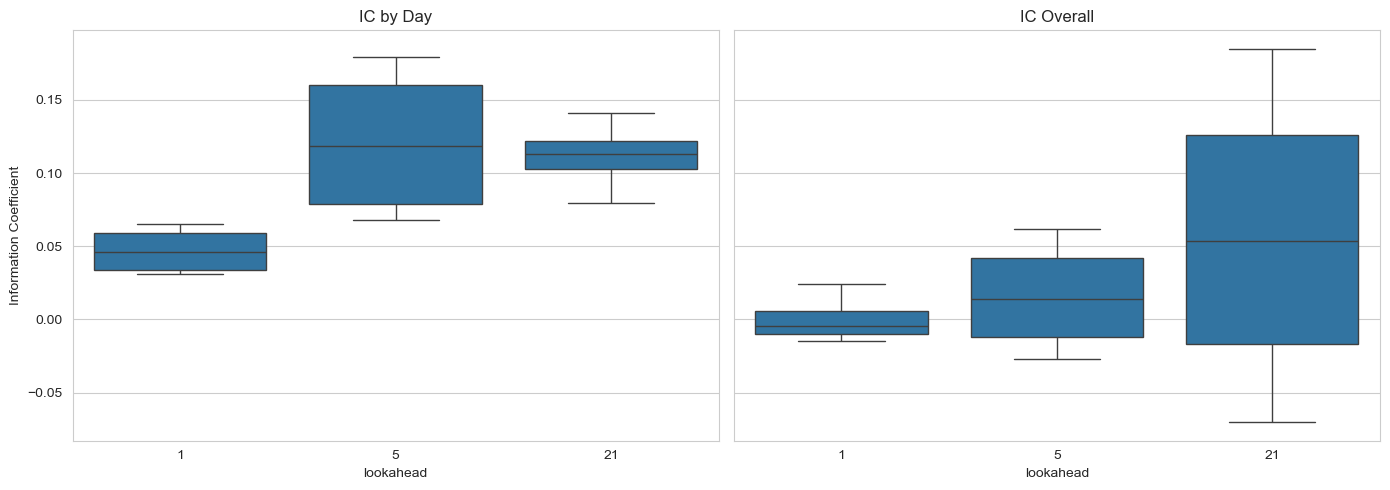

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()
plt.show()

### Best Train/Test Period Lengths

For one- and five-day return forecasts, shorter train- and test-length yield better results in terms of daily avg IC:

In [18]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

C:\Users\flyin\AppData\Local\Temp\ipykernel_197844\3061314831.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, 'ic_by_day')))


,lookahead,train_length,test_length,ic_by_day,ic
3,1,252,21,0.064862,-0.008522
1,1,1134,21,0.056733,-0.000307
2,1,252,63,0.034759,-0.014509
7,5,252,21,0.179508,-0.027056
5,5,1134,21,0.153676,-0.006718
4,5,1134,63,0.082903,0.061900
9,21,1134,21,0.140735,0.000743
11,21,252,21,0.115290,-0.070178
8,21,1134,63,0.110441,0.106169


In [19]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM Model Tuning

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [20]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The `base_params` are not affected by cross-validation:

In [21]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

We choose the following parameters and values to select our best model (see book chapter for detail):

In [22]:
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]

In [23]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [24]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [25]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

We only use test periods of 63 days length to save some model training and evaluation time.

In [26]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [27]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

We integer-encode categorical variables with values starting at zero, as expected by LightGBM (not necessary
as long as the category codes have values less than $2^{32}$, but avoids a warning)

In [28]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [29]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

To explore the hyperparameter space, we specify values for key parameters that we would like to test in combination. The sklearn library supports `RandomizedSearchCV` to cross-validate a subset of parameter combinations that are sampled randomly from specified distributions. We will implement a custom version that allows us to monitor performance so we can abort the search process once we're satisfied with the result, rather than specifying a set number of iterations beforehand.

In [30]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [31]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [32]:
label_dict = dict(zip(lookaheads, labels))

In [33]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [34]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [35]:
import lightgbm as lgb
print(lgb.__version__)


4.4.0


We iterate over our six CV configurations and collect the resulting metrics:

In [36]:
import torch
print(torch.cuda.is_available())


False


In [37]:
import lightgbm as lgb
import numpy as np

# Sample dataset
X_train = np.random.rand(1000, 10)
y_train = np.random.randint(2, size=1000)

# Dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Set parameters for using GPU
params = {
    'device_type': 'gpu',  # Use GPU
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1
}

# Try to train the model to see if GPU is available
try:
    model = lgb.train(params, train_data, num_boost_round=10)
    print("GPU is available and LightGBM is using it.")
except Exception as e:
    print("GPU is not available or not configured correctly.")
    print(e)


GPU is not available or not configured correctly.
GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


In [40]:
import os
import torch
import lightgbm as lgb
from time import time
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Helper function to ensure directories exist
def ensure_directory_exists(path):
    os.makedirs(path, exist_ok=True)

# Function to check GPU support and set LightGBM parameters
def set_lgb_params():
    if torch.cuda.is_available():
        return {'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
    else:
        return {'device': 'cpu'}

# Function to train LightGBM models and save results to HDF5
def train_lightgbm(data, test_params, cv_params, param_names, categoricals, label_dict, num_iterations, num_boost_round, metric_cols, lgb_store):
    with pd.HDFStore(lgb_store, 'w') as store:  # Open HDF5 file in write mode
        for lookahead, train_length, test_length in test_params:
            # Randomized grid search
            cvp = np.random.choice(list(range(len(cv_params))), size=int(len(cv_params) / 2), replace=False)
            cv_params_ = [cv_params[i] for i in cvp]

            # Set up cross-validation
            n_splits = int(2 * 252 / test_length)  # Assuming YEAR is 252 trading days
            print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

            # Time-series cross-validation
            cv = MultipleTimeSeriesCV(n_splits=n_splits, lookahead=lookahead, test_period_length=test_length, train_period_length=train_length)

            label = label_dict[lookahead]
            outcome_data = data.loc[:, data.columns.difference([label])].join(data[label]).dropna()

            # Drop 'metadata_sector' if present
            if 'metadata_sector' in outcome_data.columns:
                outcome_data = outcome_data.drop(columns=['metadata_sector'])

            # LightGBM Dataset preparation
            lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1), label=outcome_data[label], categorical_feature=categoricals, free_raw_data=False)

            # Initialize lists for storing results
            predictions_list, metrics_list, feature_importance_list, daily_ic_list = [], [], [], []

            # Iterate over hyperparameter combinations
            for p, param_vals in enumerate(cv_params_):
                key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
                params = dict(zip(param_names, param_vals))
                params.update(base_params)
                params.update(set_lgb_params())  # GPU/CPU settings

                start = time()
                cv_preds, nrounds = [], []
                ic_cv = defaultdict(list)

                # Iterate over folds
                for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                    lgb_train = lgb_data.subset(used_indices=train_idx.tolist(), params=params).construct()
                    model = lgb.train(params=params, train_set=lgb_train, num_boost_round=num_boost_round)

                    # Capture predictions
                    test_set = outcome_data.iloc[test_idx, :]
                    X_test = test_set.loc[:, model.feature_name()]
                    y_test = test_set.loc[:, label]
                    y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}

                    # Collect fold predictions
                    cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))

                    # Collect feature importance
                    if i == 0:
                        fi = get_fi(model).to_frame()
                    else:
                        fi[i] = get_fi(model)

                # Combine fold results and collect metrics
                cv_preds = pd.concat(cv_preds).assign(**params)
                predictions_list.append(cv_preds)

                # IC Calculation per day
                by_day = cv_preds.groupby(level='date')
                ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                                       for n in num_iterations], axis=1)

                # Collect IC and feature importance
                daily_ic_list.append(ic_by_day)
                feature_importance_list.append(fi)

                # Compute overall metrics
                daily_ic_mean = ic_by_day.mean()
                daily_ic_mean_n = daily_ic_mean.idxmax()
                daily_ic_median = ic_by_day.median()
                daily_ic_median_n = daily_ic_median.idxmax()

                # Compute IC across all predictions
                ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
                elapsed_time = time() - start

                # Collect metrics
                metrics = pd.Series(list(param_vals) +
                                    [elapsed_time, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                                    index=metric_cols)
                metrics_list.append(metrics)

                # Log status
                print(f'Params: {params} | IC max: {max(ic):.2%} | Daily IC max: {daily_ic_mean.max():.2%} | Time: {elapsed_time:.2f}s')

            # Save results to HDF5
            store.append(f'predictions/{key}', pd.concat(predictions_list))
            store.append(f'metrics/{key}', pd.DataFrame(metrics_list))
            store.append(f'daily_ic/{key}', pd.concat(daily_ic_list))
            store.append(f'feature_importance/{key}', pd.concat(feature_importance_list))

# Main execution logic
if __name__ == "__main__":
    # Define parameters here (like base_params, max_depths, etc.)
    # Example base parameters
    base_params = dict(
        boosting='gbdt',
        objective='regression',
        metric='rmse',
        verbose=-1
    )

    # Define hyperparameters
    max_depths = [2, 3, 5, 7]
    num_leaves_opts = [2 ** i for i in max_depths]
    min_data_in_leaf_opts = [250, 500, 1000]
    learning_rate_opts = [.01, .1, .3]
    feature_fraction_opts = [.3, .6, .95]

    param_names = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
    cv_params = list(product(learning_rate_opts, num_leaves_opts, feature_fraction_opts, min_data_in_leaf_opts))

    n_params = len(cv_params)
    print(f'# Parameters: {n_params}')

    lookaheads = [1, 5, 21]
    train_lengths = [int(4.5 * 252), 252]
    test_lengths = [63]
    test_params = list(product(lookaheads, train_lengths, test_lengths))

    n = len(test_params)
    test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
    test_params = [test_params[i] for i in test_param_sample]
    print('Train configs:', len(test_params))

    # Categorical features
    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    # Label dictionary for lookahead
    label_dict = dict(zip(lookaheads, sorted(data.filter(like='fwd').columns)))
    features = data.columns.difference(label_dict.values()).tolist()
    

    # Define iterations and metrics columns
    num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
    num_boost_round = num_iterations[-1]
    metric_cols = param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n'] + [str(n) for n in num_iterations]

    # Results path
    results_path = Path('results/us_stocks')
    lgb_store = results_path / 'tuning_lgb.h5'

    # Run the training
    train_lightgbm(data, test_params, cv_params, param_names, categoricals, label_dict, num_iterations, num_boost_round, metric_cols, lgb_store)


# Parameters: 108
Train configs: 6
Lookahead: 21 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
Params: {'learning_rate': 0.3, 'num_leaves': 8, 'feature_fraction': 0.95, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 75.74% | Daily IC max: 76.19% | Time: 39.38s
Params: {'learning_rate': 0.1, 'num_leaves': 32, 'feature_fraction': 0.6, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 75.19% | Daily IC max: 76.21% | Time: 49.11s
Params: {'learning_rate': 0.3, 'num_leaves': 8, 'feature_fraction': 0.3, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 75.24% | Daily IC max: 76.23% | Time: 30.10s
Params: {'learning_rate': 0.01, 'num_leaves': 4, 'feature_fraction': 0.95, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regres

c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
 

Lookahead:  5 | Train: 252 | Test: 63 | Params:  54 | Train configs: 6
Params: {'learning_rate': 0.3, 'num_leaves': 4, 'feature_fraction': 0.3, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 67.99% | Daily IC max: 69.07% | Time: 15.85s
Params: {'learning_rate': 0.1, 'num_leaves': 32, 'feature_fraction': 0.6, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 68.37% | Daily IC max: 69.33% | Time: 28.67s
Params: {'learning_rate': 0.1, 'num_leaves': 4, 'feature_fraction': 0.95, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 69.09% | Daily IC max: 69.95% | Time: 16.38s
Params: {'learning_rate': 0.1, 'num_leaves': 4, 'feature_fraction': 0.3, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1,

c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '252'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  c

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
Params: {'learning_rate': 0.1, 'num_leaves': 128, 'feature_fraction': 0.95, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 40.05% | Daily IC max: 39.99% | Time: 91.25s
Params: {'learning_rate': 0.01, 'num_leaves': 8, 'feature_fraction': 0.95, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 40.55% | Daily IC max: 40.62% | Time: 38.68s
Params: {'learning_rate': 0.1, 'num_leaves': 128, 'feature_fraction': 0.95, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 40.04% | Daily IC max: 39.97% | Time: 109.92s
Params: {'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.6, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'v

c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  

Lookahead:  1 | Train: 252 | Test: 63 | Params:  54 | Train configs: 6
Params: {'learning_rate': 0.01, 'num_leaves': 4, 'feature_fraction': 0.3, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 38.60% | Daily IC max: 38.79% | Time: 14.70s
Params: {'learning_rate': 0.1, 'num_leaves': 32, 'feature_fraction': 0.95, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 39.12% | Daily IC max: 40.09% | Time: 31.47s
Params: {'learning_rate': 0.1, 'num_leaves': 32, 'feature_fraction': 0.6, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 38.56% | Daily IC max: 38.99% | Time: 27.59s
Params: {'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.95, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbos

c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '252'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
 

Lookahead: 21 | Train: 252 | Test: 63 | Params:  54 | Train configs: 6
Params: {'learning_rate': 0.3, 'num_leaves': 32, 'feature_fraction': 0.6, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 74.05% | Daily IC max: 75.34% | Time: 25.98s
Params: {'learning_rate': 0.01, 'num_leaves': 128, 'feature_fraction': 0.6, 'min_data_in_leaf': 1000, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 74.27% | Daily IC max: 75.77% | Time: 45.57s
Params: {'learning_rate': 0.3, 'num_leaves': 4, 'feature_fraction': 0.3, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 74.38% | Daily IC max: 75.59% | Time: 14.51s
Params: {'learning_rate': 0.1, 'num_leaves': 32, 'feature_fraction': 0.6, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose'

c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '252'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0.01'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though


Lookahead:  5 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
Params: {'learning_rate': 0.1, 'num_leaves': 4, 'feature_fraction': 0.6, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 69.14% | Daily IC max: 69.82% | Time: 33.72s
Params: {'learning_rate': 0.01, 'num_leaves': 4, 'feature_fraction': 0.3, 'min_data_in_leaf': 500, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 67.62% | Daily IC max: 68.14% | Time: 29.48s
Params: {'learning_rate': 0.3, 'num_leaves': 4, 'feature_fraction': 0.95, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'device': 'cpu'} | IC max: 68.99% | Daily IC max: 69.57% | Time: 35.25s
Params: {'learning_rate': 0.3, 'num_leaves': 128, 'feature_fraction': 0.95, 'min_data_in_leaf': 250, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbose':

c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\flyin\.conda\envs\py311\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though


In [64]:
# Save the trained LightGBM model to a file
model.save_model('trained_model.txt')


## CatBoost Model Tuning

We repeat a similar process for CatBoost - see book and CatBoost [docs](https://catboost.ai/docs/concepts/about.html) for detail.

### Hyperparameter Options

In [65]:
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]

In [66]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [67]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [68]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [69]:
test_params = list(product(lookaheads,
                           train_lengths,
                           test_lengths))

### Custom Loss Function

In [70]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### Run Cross-Validation

In [71]:
cb_store = Path(results_path / 'tuning_catboost.h5')

In [72]:
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]

In [73]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [75]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from collections import defaultdict
from time import time
from scipy.stats import spearmanr
from pathlib import Path
from itertools import product

# Ensure directory exists function
def ensure_directory_exists(path):
    path.parent.mkdir(parents=True, exist_ok=True)

# CatBoostIC metric
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether greater values of the metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of the metric based on error and weight
        return error

# Function to run CatBoost training
def train_catboost(data, test_params, cv_params, param_names, categoricals, label_dict, num_iterations, metric_cols, cb_store):
    for lookahead, train_length, test_length in test_params:
        cvp = np.random.choice(list(range(len(cv_params))),
                               size=int(len(cv_params) / 1),
                               replace=False)
        cv_params_ = [cv_params[i] for i in cvp]

        n_splits = int(2 * 252 / test_length)  # Assuming YEAR is 252 trading days
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | Test: {test_length:2.0f} | '
              f'Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

        # Time-series cross-validation
        cv = MultipleTimeSeriesCV(n_splits=n_splits, lookahead=lookahead, test_period_length=test_length, train_period_length=train_length)

        label = label_dict[lookahead]
        outcome_data = data.loc[:, data.columns.difference([label])].join(data[label]).dropna()

        # Ensure 'capital_goods' is treated as a categorical feature or removed if not needed
        if 'capital_goods' in outcome_data.columns:
            outcome_data['capital_goods'] = outcome_data['capital_goods'].astype('category')

        # Ensure categorical columns are properly set
        outcome_data[categoricals] = outcome_data[categoricals].astype('category')

        # Prepare CatBoost Pool with corrected features
        cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
        catboost_data = Pool(label=outcome_data[label],
                             data=outcome_data.drop(label, axis=1),
                             cat_features=cat_cols_idx)

        predictions, metrics, feature_importance, daily_ic = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0

        for p, param_vals in enumerate(cv_params_):
            params = dict(zip(param_names, param_vals))
            # uncomment if running with GPU
            # params['task_type'] = 'GPU'

            start = time()
            cv_preds, nrounds = [], []
            ic_cv = defaultdict(list)

            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                train_set = catboost_data.slice(train_idx.tolist())

                model = CatBoostRegressor(**params)
                model.fit(X=train_set, verbose=False)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_names_]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, ntree_end=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))

            # Combine fold results
            cv_preds = pd.concat(cv_preds).assign(**params)
            predictions.append(cv_preds)

            # Compute IC per day
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)
            daily_ic_mean = ic_by_day.mean()
            daily_ic_mean_n = daily_ic_mean.idxmax()
            daily_ic_median = ic_by_day.median()
            daily_ic_median_n = daily_ic_median.idxmax()

            # Compute IC across all predictions
            ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
            t = time() - start
            T += t

            # Collect metrics
            metrics = pd.Series(list(param_vals) +
                                [t, daily_ic_mean.max(), daily_ic_mean_n,
                                 daily_ic_median.max(), daily_ic_median_n] + ic,
                                index=metric_cols)
            
            msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
            msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
            print(msg)

            # Ensure the directories exist before saving the files
            predictions_path = f'predictions/{key}'
            metrics_path = f'metrics/{key}'
            ic_by_day_path = f'daily_ic/{key}'
            fi_path = f'fi/{key}'

            ensure_directory_exists(Path(predictions_path))
            ensure_directory_exists(Path(metrics_path))
            ensure_directory_exists(Path(ic_by_day_path))
            ensure_directory_exists(Path(fi_path))

            # Save the results as Parquet
            cv_preds.to_parquet(f'{predictions_path}.parquet')
            metrics.to_frame().to_parquet(f'{metrics_path}.parquet')  # Convert Series to DataFrame
            ic_by_day.assign(**params).to_parquet(f'{ic_by_day_path}.parquet')

# Main execution
if __name__ == "__main__":
    # Define parameters
    param_names = ['max_depth', 'min_child_samples']

    max_depth_opts = [3, 5, 7, 9]
    min_child_samples_opts = [20, 250, 500]

    cv_params = list(product(max_depth_opts, min_child_samples_opts))
    n_params = len(cv_params)

    lookaheads = [1, 5, 21]
    label_dict = dict(zip(lookaheads, labels))  # Define labels appropriately

    train_lengths = [int(4.5 * 252), 252]
    test_lengths = [63]
    test_params = list(product(lookaheads, train_lengths, test_lengths))

    num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
    metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                                  'daily_ic_median', 'daily_ic_median_n'] +
                   [str(n) for n in num_iterations])

    results_path = Path('results/us_stocks')
    cb_store = results_path / 'tuning_catboost.h5'

    categoricals = ['year', 'weekday', 'month']  # Define appropriate categorical features
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    # Run the CatBoost training
    train_catboost(data, test_params, cv_params, param_names, categoricals, label_dict, num_iterations, metric_cols, cb_store)


Lookahead:  1 | Train: 1134 | Test: 63 | Params:  12 | Train configs: 6


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=8]="capital_goods": Cannot convert 'b'capital_goods'' to float

In [45]:
# Check data types of all columns
print(outcome_data.dtypes)


ATR                 float64
MACD                float64
NATR                float64
PPO                 float64
bb_high             float64
bb_low              float64
dollar_vol          float64
dollar_vol_rank     float64
metadata_sector      object
month              category
r01                 float64
r01dec              float64
r01q_sector         float64
r05                 float64
r05dec              float64
r05q_sector         float64
r10                 float64
r10dec              float64
r10q_sector         float64
r21                 float64
r21dec              float64
r21q_sector         float64
r42                 float64
r42dec              float64
r42q_sector         float64
r63                 float64
r63dec              float64
r63q_sector         float64
rsi                 float64
sector                int64
weekday            category
year               category
r01_fwd             float64
dtype: object
